In [1]:
import pandas as pd
import datetime
import re
import xarray as xr
import numpy as np 
import xroms
import pyresample 
import metpy
import matplotlib.pyplot as plt
import os, glob
import gsw
#FUNCTIONS

# TEXTFILE TO PANDAS
def txt_to_pd(txtfile,LAT,LON):

    columns_to_keep = ['T_degC', 'T_qf', 'S', 'S_qf', 'Date', 'Time'] 
    new_column_names = ['TEMP','TEMP_QC','PSAL','PSAL_QC','Date','Time']


    # Hvis vi vil at pandas skal tolke dato som som et datetime object 
    # kan vi gi informasjon om hvordan dato stirngene er formatert med parser.  
    #
    # For denne filen vil det kunne se slik ut:
    # parse = lambda x: datetime.datetime.strptime(x, '%d %b %Y %H:%M:%S')
    # Betydningen av de ulike %bokstaven finnes her: (https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

    # Men for å gjøre ting litt vanskligere er det brukt norske forkortelser for månedsnavn... 
    # Vi bytter enkelt ut norske forkortelser med engelske ved å bruke metoden .replace(norsk, engelsk)

    parse = lambda x: datetime.datetime.strptime(x.replace('Des', 'Dec').replace('Mai', 'May').replace('Okt', 'Oct'), '%d %b %Y %H:%M:%S')

    #df = pd.read_csv(txtfile, delimiter='\t', usecols=columns_to_keep, parse_dates={"Datetime" : ['Date', 'Time']}, date_parser = parse)
    df = pd.read_csv(txtfile, delimiter='\t', usecols=columns_to_keep)
    df.columns = new_column_names
    
    # Combine Date and Time columns and strip any leading or trailing whitespace
    df['TIME'] = (df['Date'] + ' ' + df['Time']).str.strip()
    
    # Apply the custom parsing function
    df['TIME'] = df['TIME'].apply(parse)
    df.drop(columns=['Date', 'Time'], inplace=True)
    
    # Add depth:
    df['DEPTH'] = get_depth(txtfile)
    df['LAT'] = LAT
    df['LON'] = LON
    return(df)

#NETCDF FILE TO PANDAS:
def netcdf_to_pd(txt):
    # Load the NetCDF file using xarray
    ds = xr.open_dataset(txt)

    # Select the variables you are interested in
    variables = ['TEMP', 'TEMP_QC', 'PSAL', 'PSAL_QC']

    # Initialize an empty DataFrame to merge into
    df_combined = pd.DataFrame()

    # Loop over each variable to process and merge
    for var in variables:

        # Select the variable data
        data = ds[var]
    
        # Stack the depth and time dimensions into a MultiIndex
        stacked_data = data.stack(points=('DEPTH', 'TIME'))
    
    
        # Convert the stacked DataArray to a pandas DataFrame
        df = stacked_data.to_dataframe()
            
        # Temporarily rename columns to avoid conflicts
        df.rename(columns={'DEPTH': 'Depth_col', 'TIME': 'Time_col', 'LONGITUDE': 'LON_col'}, inplace=True)
        #        
        df = df.reset_index()
        df.drop(columns=['Depth_col', 'Time_col'], inplace=True)
        #    
        # If df_combined is empty, initialize it with the current DataFrame
        if df_combined.empty:
            df_combined = df
        else:
            # Merge the current DataFrame with the combined DataFrame
            df_combined = pd.merge(df_combined, df, on=['DEPTH', 'TIME'], how='outer')  
    df_combined['LON'] = ds['LONGITUDE'].values[0]
    df_combined['LAT'] = ds['LATITUDE'].values[0]
    return(df_combined)     

#CSV FILE TO PANDAS:
def csv_to_pd(csvfile, lat, lon):
    names = ['timestamp', 'ensemble', 'ErrorFlags', 'Temperature', 'Pressure', 'Salinity']

    parse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

    df = pd.read_csv(csvfile, names=names, header=1, usecols=[1, 2, 3, 4, 5, 6], infer_datetime_format=True, parse_dates=["timestamp"], date_parser=parse)

    df['DEPTH'] = np.abs(gsw.z_from_p(df['Pressure'], lat))
    df['LATITUDE'] = lat
    df['LONGITUDE'] = lon
    
    df.rename(columns={'timestamp': 'TIME', 'Temperature': 'TEMP', 'Salinity': 'PSAL'}, inplace=True)
    
    df['TIME'] = pd.to_datetime(df['TIME'])
    return df  

# GET DEPTH FROM FILENAME
def get_depth(filename):
    # Use a regular expression to extract the depth value
    depth_match = re.search(r'_(\d+)m', filename)
    if depth_match:
        depth_value = int(depth_match.group(1))
    else:
        depth_value = None
    return(depth_value)   

# FIND DEPTH INDEX IN ROMS (weighted mean)
def get_Zindices(ds,X,Y,target_depth):
    ds = ds.isel(xi_rho = X, eta_rho = Y)

    # Extract the z_rho values at the given point
    z_rho_values = ds.z_rho.values
    s_rho_values = ds.s_rho.values

    diff = np.abs(z_rho_values - target_depth)
    diff = diff.squeeze()
    
    # Find the indices of the two smallest differences
    closest_indices = diff.argsort()[:2]
    
    # Calculate the weights as the inverse of the differences
    # Adding a small epsilon to avoid division by zero
    epsilon = 1e-10
    weights = 1 / (diff[closest_indices] + epsilon)

    # Normalize the weights so that they sum to 1
    weights /= weights.sum()
    
    return(weights,closest_indices)

# FIND TIME-INDEX IN ROMS RELATIVE TO OBSERVATION TIME
def find_time_index(r_time,ocean_time):
    days_since_1970 = (r_time - datetime.datetime(1970,1,1,0,0,0)).total_seconds()
    ocean_time = pd.to_datetime(ocean_time)
    # Convert ocean_time
    ocean_time_since_1970 = (ocean_time - datetime.datetime(1970,1,1,0,0,0)).total_seconds()
    index = np.abs(ocean_time_since_1970 - days_since_1970).argmin()
    return(index)

# FIND THE Barents-MODEL's X AND Y POSITIONS
def get_XYpositions(filename, lons, lats):
    
    fh = xr.open_dataset(filename)
    x   = np.linspace(0, fh.lat_rho.values.shape[1]-1, fh.lat_rho.values.shape[1])
    y   = np.linspace(0, fh.lat_rho.values.shape[0]-1, fh.lat_rho.values.shape[0])
    xi  = np.zeros_like(fh.lon_rho.values)
    yi  = np.zeros([fh.lon_rho.values.shape[1], fh.lon_rho.values.shape[0]])
    xi[:,:] = x
    yi[:,:] = y
    yi  = np.swapaxes(yi, 1, 0)

    # First I define the wet points of the field as the lon,lat values with mask_rho==1, for Barents use sea_mask==1
    sea_def = pyresample.geometry.SwathDefinition(lons= fh.lon_rho.values[np.where(fh.mask_rho)], lats = fh.lat_rho.values[np.where(fh.mask_rho)])

    # Second, the full grid definiton (our target domain):
    orig_def = pyresample.geometry.SwathDefinition(lons=lons, lats=lats)

    # Then I fill the temperature field by the nearest neighbour approace.
    # Note that only wet points are used as input. 

    # The radius of influence sets a limit (in meters) for how far away a true value can be from the point that will be filled

    ypos = pyresample.kd_tree.resample_nearest(sea_def, yi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)

    xpos = pyresample.kd_tree.resample_nearest(sea_def, xi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)
    return np.array([int(x) for x in xpos]), np.array([int(y) for y in ypos])


# MAIN FUNCTION THAT EXTRACTS DATA FROM THE ROMS/Barents MODEL, AS LONG AS THE PANDAS DATAFRAME IS GROUPED INTO DAYS
def extract_data_for_group(group,dsG,var='temp'):
    # Define a function to extract data for each group:
    date = group['DAY'].iloc[0]  # All rows in the group have the same date
    year = date.strftime('%Y')
    month = date.strftime('%m')
    day = date.strftime('%d')
    
    #file_path = f'https://thredds.met.no/thredds/dodsC/sea_norshelf_files/{year}/{month}/norshelf_qck_an_{year}{month}{day}T00Z.nc'
 
    file_path = f"https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_sdepth/barents_his_{year}{month}{day}T00Zm00_AN.nc"
    #f"https://thredds.met.no/thredds/dodsC/barents25km_files/Barents-2.5km_ZDEPTHS_his.an.2020061100.nc"
                  
    # Read the file and extract data (assuming file has some structured data)
    
    try:
    
        with xr.open_dataset(file_path) as ds:
            # Selcect variables: 
            ds = ds.get([var])
            # Here we simulate extracting relevant data from the file for each x, y
            extracted_data = []
            for _, row in group.iterrows():
                x, y = row['X'], row['Y']

                #fine time-index
                r_time = row['TIME']
                ocean_time = ds.ocean_time.values
                index = find_time_index(r_time,ocean_time)
                
                #find depth index to interpolate over:
                depth = row['DEPTH']
                weights,indices = get_Zindices(dsG,10,10,depth*-1)
                # Data extraction based on x, y, time and s_rho
                temp1 = ds.isel(ocean_time=index,s_rho = indices[0], xi_rho = int(x), eta_rho = int(y))[var].values
                temp2 = ds.isel(ocean_time=index,s_rho = indices[1], xi_rho = int(x), eta_rho = int(y))[var].values
                # Calculate the weighted average temperature
                weighted_temperature = temp1 * weights[0] + temp2 * weights[1]
                extracted_data.append(weighted_temperature)
            return extracted_data
    except:
        extracted_data = []
        for _, row in group.iterrows():
            extracted_data.append(np.nan)
        return extracted_data   
    

In [3]:
#FILES:
# Grid file Norshelf:
#gridfile = '/lustre/storeB/project/fou/hi/oper/norshelf/static_inputfiles/norshelf_2.4_vert_grd.nc'
# Grid file Barents: 
gridfile = '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/static/obs_grid_file.nc'

#dsg = xr.open_dataset(gridfile)


In [4]:
INfile = "/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/SouthCape/T_S_SouthCape.csv"
ds = csv_to_pd(INfile, 76.107, 15.967)

x,y = get_XYpositions(gridfile, ds.LONGITUDE.values, ds.LATITUDE.values)
ds['X'] = x
ds['Y'] = y
print(x)
print(y)

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in z_from_p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[292 292 292 ... 292 292 292]
[444 444 444 ... 444 444 444]


In [6]:
# ADD INFORMATION TO GRIDFILE TO FIND DEPTH-index:
# Load your ROMS dataset
dsG = xr.open_dataset(gridfile)
print(dsG.lat_rho.values[444, 292])
dsG = dsG.xroms.subset(X=slice(292-10,292+10), Y=slice(444-10,444+10))
print(dsG.lat_rho.values[10, 10])
# Initialize the ROMS dataset and create the grid object
#dsG, xgrid = xroms.roms_dataset(dsG, include_cell_volume = True, include_Z0=True)
dsG, xgrid = xroms.roms_dataset(dsG, include_cell_volume = True, include_Z0 = True)

# Associate the dataset with the grid
dsG.xroms.set_grid(xgrid)

76.1023941040039
76.1023941040039


In [23]:
dsG

<xarray.Dataset>
Dimensions:                  (ocean_time: 1, s_w: 43, eta_rho: 20, xi_rho: 20,
                              tracer: 2, s_rho: 42, boundary: 4, eta_v: 19,
                              xi_u: 19)
Coordinates: (12/31)
    lat_psi                  (eta_v, xi_u) float64 ...
    lat_rho                  (eta_rho, xi_rho) float64 76.07 76.06 ... 76.12
    lat_u                    (eta_rho, xi_u) float64 ...
    lat_v                    (eta_v, xi_rho) float64 ...
    lon_psi                  (eta_v, xi_u) float64 ...
    lon_rho                  (eta_rho, xi_rho) float64 14.7 14.77 ... 17.13 17.2
    ...                       ...
    z_rho_v0                 (s_rho, eta_v, xi_rho) float64 -334.5 ... -0.9005
    z_rho_psi0               (s_rho, eta_v, xi_u) float64 -333.6 ... -0.8998
    z_w0                     (s_w, eta_rho, xi_rho) float64 -352.5 ... 0.0
    z_w_u0                   (s_w, eta_rho, xi_u) float64 -351.0 -348.7 ... 0.0
    z_w_v0                   (s_w, eta_v, xi_rho) float64 -351.9 -350.0 ... 0.0
    z_w_psi0                 (s_w, eta_v, xi_u) float64 -350.9 -349.8 ... 0.0
Dimensions without coordinates: tracer, boundary
Data variables: (12/134)
    AKs                      (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    Akk_bak                  float64 ...
    Akp_bak                  float64 ...
    Akt_bak                  (tracer) float64 ...
    Akv_bak                  float64 ...
    Charnok_alpha            float64 ...
    ...                       ...
    dV_u                     (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 42, 20, 19), meta=np.ndarray>
    dV_w_u                   (ocean_time, s_w, eta_rho, xi_u) float64 -2.101e...
    dV_v                     (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 42, 19, 20), meta=np.ndarray>
    dV_w_v                   (ocean_time, s_w, eta_v, xi_rho) float64 -2.106e...
    dV_psi                   (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 42, 19, 19), meta=np.ndarray>
    dV_w_psi                 (ocean_time, s_w, eta_v, xi_u) float64 -2.101e+0...
Attributes: (12/31)
    file:              /home/havis/run/barents-2.5km/ocean_his.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Barents-2.5km - ROMS
    var_info:          /home/havis/sea/ROMS/metroms_apps/barents-2.5km/includ...
    ...                ...
    compiler_flags:    -xHost  -I/lustre/storeB/project/fou/hi/arktis2030/met...
    tiling:            003x036
    history:           Mon Feb 15 10:46:07 2021: ncks -d ocean_time,0 ocean_h...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       BARENTS, ADD_FSOBC, ADD_M2OBC, ALBEDO, ANA_BSFLUX, ANA...
    NCO:               "4.5.4"

In [8]:
dsG

<xarray.Dataset>
Dimensions:                  (ocean_time: 1, s_w: 43, eta_rho: 50, xi_rho: 20,
                              tracer: 2, s_rho: 42, boundary: 4, eta_v: 49,
                              xi_u: 19)
Coordinates: (12/31)
    lat_psi                  (eta_v, xi_u) float64 ...
    lat_rho                  (eta_rho, xi_rho) float64 70.34 70.34 ... 71.36
    lat_u                    (eta_rho, xi_u) float64 ...
    lat_v                    (eta_v, xi_rho) float64 ...
    lon_psi                  (eta_v, xi_u) float64 ...
    lon_rho                  (eta_rho, xi_rho) float64 -16.24 -16.18 ... -14.42
    ...                       ...
    z_rho_v0                 (s_rho, eta_v, xi_rho) float64 -1.043e+03 ... -1...
    z_rho_psi0               (s_rho, eta_v, xi_u) float64 -1.045e+03 ... -1.12
    z_w0                     (s_w, eta_rho, xi_rho) float64 -1.12e+03 ... 0.0
    z_w_u0                   (s_w, eta_rho, xi_u) float64 -1.122e+03 ... 0.0
    z_w_v0                   (s_w, eta_v, xi_rho) float64 -1.105e+03 ... 0.0
    z_w_psi0                 (s_w, eta_v, xi_u) float64 -1.108e+03 ... 0.0
Dimensions without coordinates: tracer, boundary
Data variables: (12/134)
    AKs                      (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    Akk_bak                  float64 ...
    Akp_bak                  float64 ...
    Akt_bak                  (tracer) float64 ...
    Akv_bak                  float64 ...
    Charnok_alpha            float64 ...
    ...                       ...
    dV_u                     (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 42, 50, 19), meta=np.ndarray>
    dV_w_u                   (ocean_time, s_w, eta_rho, xi_u) float64 -6.58e+...
    dV_v                     (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 42, 49, 20), meta=np.ndarray>
    dV_w_v                   (ocean_time, s_w, eta_v, xi_rho) float64 -6.48e+...
    dV_psi                   (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 42, 49, 19), meta=np.ndarray>
    dV_w_psi                 (ocean_time, s_w, eta_v, xi_u) float64 -6.494e+0...
Attributes: (12/31)
    file:              /home/havis/run/barents-2.5km/ocean_his.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Barents-2.5km - ROMS
    var_info:          /home/havis/sea/ROMS/metroms_apps/barents-2.5km/includ...
    ...                ...
    compiler_flags:    -xHost  -I/lustre/storeB/project/fou/hi/arktis2030/met...
    tiling:            003x036
    history:           Mon Feb 15 10:46:07 2021: ncks -d ocean_time,0 ocean_h...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       BARENTS, ADD_FSOBC, ADD_M2OBC, ALBEDO, ANA_BSFLUX, ANA...
    NCO:               "4.5.4"

In [7]:
#South Cape mooring (csv)
INfile = "/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/SouthCape/T_S_SouthCape.csv"

#StationM (txt)
#'/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment3/StaM_SBE_20221125_2000m.txt'

#StationM (netCDF):
#INfile = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment1/StationM_2021_hydrography.nc'

In [8]:
# FIND X and Y:

# READING CSV FILE:
ds = csv_to_pd(INfile, 76.107, 15.967)

# READING TEXT FILES
# ds = txt_to_pd(INfile,66.015,1.983)

# READING NETCDF FILES:
#ds = netcdf_to_pd(INfile)

# MOVE THIS INTO A FUNCTION AND RE-USE THEM IN THE FUNCTIONS txt_to_pd and netcdf_to_pd

x,y = get_XYpositions(gridfile, ds.LONGITUDE.values, ds.LATITUDE.values)
ds['X'] = x
ds['Y'] = y


# Time to datetime:
ds['TIME'] = pd.to_datetime(ds['TIME'])

ds.set_index('TIME', inplace= True)

ds = ds.resample('H').mean()

ds = ds.rename_axis('TIME').reset_index()
#ds.reset_index(level=['TIME'])


# Round the TIME column to the nearest hour:
#ds['TIME'] = ds['TIME'].dt.round('H')

# Round the TIME column to the nearest day:
ds['DAY'] = ds['TIME'].dt.date
print(ds.head())
# Extract unique months (Year-Month) from the date column
ds['year_month'] = ds['TIME'].dt.to_period('M')

# Test-data
#ds=ds.head(50)


/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in z_from_p
  result = getattr(ufunc, method)(*inputs, **kwargs)


                 TIME  ensemble  ErrorFlags      TEMP    Pressure       PSAL  \
0 2022-04-13 07:00:00       4.0        20.0  1.681440  380.477000  35.188080   
1 2022-04-13 08:00:00      12.5        20.0  1.754808  380.570583  34.938325   
2 2022-04-13 09:00:00      24.5        20.0  1.793025  380.632583  34.864558   
3 2022-04-13 10:00:00      36.5        20.0  1.795467  380.610250  34.829108   
4 2022-04-13 11:00:00      48.5        20.0  1.784008  380.496000  34.820783   

        DEPTH  LATITUDE  LONGITUDE      X      Y         DAY  
0  376.160146    76.107     15.967  292.0  444.0  2022-04-13  
1  376.252583    76.107     15.967  292.0  444.0  2022-04-13  
2  376.313823    76.107     15.967  292.0  444.0  2022-04-13  
3  376.291764    76.107     15.967  292.0  444.0  2022-04-13  
4  376.178913    76.107     15.967  292.0  444.0  2022-04-13  


In [9]:
#ds2 = ds.iloc[-32:]
grouped = ds.groupby('DAY').apply(lambda group: extract_data_for_group(group,dsG,'temp'))


In [10]:
ds['TEMP_MOD'] = [item for sublist in grouped for item in sublist]

In [114]:
ds.head()

,TIME,ensemble,ErrorFlags,TEMP,Pressure,PSAL,DEPTH,LATITUDE,LONGITUDE,X,Y,DAY,year_month,TEMP_MOD
0,2022-04-13 07:00:00,4.0,20.0,1.681440,380.477000,35.188080,376.160146,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.373978
1,2022-04-13 08:00:00,12.5,20.0,1.754808,380.570583,34.938325,376.252583,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.382487
2,2022-04-13 09:00:00,24.5,20.0,1.793025,380.632583,34.864558,376.313823,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.393375
3,2022-04-13 10:00:00,36.5,20.0,1.795467,380.610250,34.829108,376.291764,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.403328
4,2022-04-13 11:00:00,48.5,20.0,1.784008,380.496000,34.820783,376.178913,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.410672


In [11]:
grouped = ds.groupby('DAY').apply(lambda group: extract_data_for_group(group,dsG,'salt'))

In [12]:
ds['SALT_MOD'] = [item for sublist in grouped for item in sublist]

In [13]:
ds.head()

,TIME,ensemble,ErrorFlags,TEMP,Pressure,PSAL,DEPTH,LATITUDE,LONGITUDE,X,Y,DAY,year_month,TEMP_MOD,SALT_MOD
0,2022-04-13 07:00:00,4.0,20.0,1.681440,380.477000,35.188080,376.160146,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.373978,34.863468
1,2022-04-13 08:00:00,12.5,20.0,1.754808,380.570583,34.938325,376.252583,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.382487,34.863429
2,2022-04-13 09:00:00,24.5,20.0,1.793025,380.632583,34.864558,376.313823,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.393375,34.863430
3,2022-04-13 10:00:00,36.5,20.0,1.795467,380.610250,34.829108,376.291764,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.403328,34.863353
4,2022-04-13 11:00:00,48.5,20.0,1.784008,380.496000,34.820783,376.178913,76.107,15.967,292.0,444.0,2022-04-13,2022-04,1.410672,34.863067


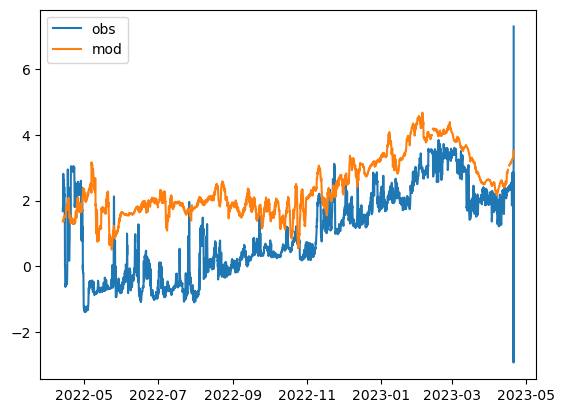

In [15]:
plt.plot(ds["TIME"], ds["TEMP"], label = "obs")
plt.plot(ds["TIME"], ds["TEMP_MOD"], label = "mod")
plt.legend()

In [18]:
ds.to_csv("southcape_data_obs_and_mod.csv")